# Equipment Anomaly Detection - Exploratory Data Analysis and ML Modeling

In this notebook, we will analyze equipment anomaly data to predict whether equipment is faulty or not. We'll perform detailed exploratory data analysis and build baseline machine learning models.

In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# ignore warning messages
import warnings
warnings.filterwarnings("ignore")

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [6]:
# import data 
df = pd.read_csv('equipment_anomaly_data.csv')
df.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


## Problem statement: 

- Trying to predict if an equipment is faulty or not

## 1. Initial Data Exploration

Let's start by exploring the dataset to understand its structure, check for missing values, and get a summary of the features.

In [8]:
# Check for missing values
print('Missing values in each column:')
print(df.isnull().sum())

# Statistical summary of numerical features
print('\nStatistical summary of numerical features:')
print(df.describe())

# Count of equipment types
print('\nEquipment types:')
print(df['equipment'].value_counts())

# Count of locations
print('\nLocations:')
print(df['location'].value_counts())

# Distribution of target variable (faulty)
print('\nTarget variable distribution:')
print(df['faulty'].value_counts())
print(f"Percentage of faulty equipment: {df['faulty'].mean()*100:.2f}%")

Missing values in each column:
temperature    0
pressure       0
vibration      0
humidity       0
equipment      0
location       0
faulty         0
dtype: int64

Statistical summary of numerical features:
       temperature     pressure    vibration     humidity       faulty
count  7672.000000  7672.000000  7672.000000  7672.000000  7672.000000
mean     70.922478    35.738048     1.611809    50.016574     0.099974
std      16.200059    10.381593     0.728560    11.841479     0.299985
min      10.269385     3.620798    -0.428188    10.215077     0.000000
25%      62.777057    29.485682     1.170906    42.612817     0.000000
50%      70.156900    35.227544     1.533113    50.024744     0.000000
75%      77.568387    41.159913     1.924700    57.340513     0.000000
max     149.690420    79.887734     4.990537    89.984718     1.000000

Equipment types:
equipment
Compressor    2573
Turbine       2565
Pump          2534
Name: count, dtype: int64

Locations:
location
Atlanta          1564


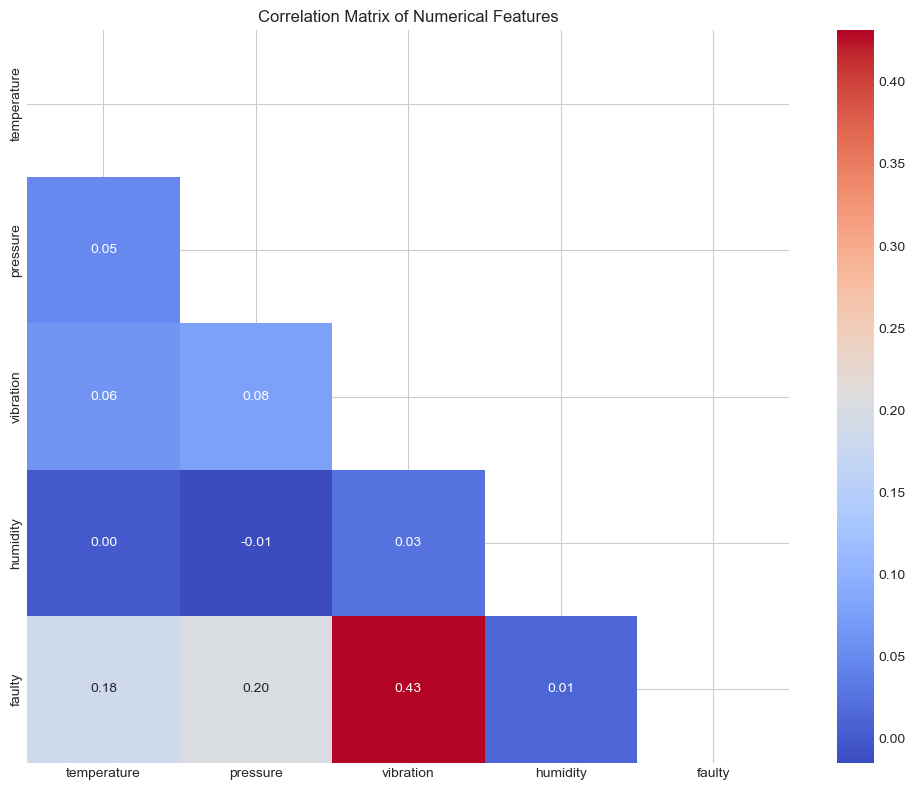

Correlations with the target variable (faulty):
temperature: 0.1843
pressure: 0.2023
vibration: 0.4314
humidity: 0.0127


In [15]:
# Check correlations between numerical features
correlation_matrix = df.select_dtypes(include='number').corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix with the mask
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Print the key correlations with the target variable
print("Correlations with the target variable (faulty):")
for col in correlation_matrix.index:
    if col != 'faulty':
        print(f"{col}: {correlation_matrix.loc[col, 'faulty']:.4f}")

## 2. Detailed Feature Analysis

Now, let's analyze each feature individually and in relation to the target variable (faulty).

In [16]:
# Creating a function to plot histograms and boxplots for each numerical feature
def analyze_numerical_feature(feature):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram with distribution by target
    sns.histplot(data=df, x=feature, hue='faulty', kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {feature} by Fault Status')
    
    # Boxplot by target
    sns.boxplot(data=df, x='faulty', y=feature, ax=axes[1])
    axes[1].set_title(f'Boxplot of {feature} by Fault Status')
    axes[1].set_xticklabels(['Not Faulty', 'Faulty'])
    
    plt.tight_layout()
    plt.show()
    
    # Calculate statistics by target group
    stats = df.groupby('faulty')[feature].agg(['mean', 'median', 'std']).reset_index()
    stats.columns = ['Faulty', feature + '_mean', feature + '_median', feature + '_std']
    print(f"Statistics for {feature}:")
    print(stats)
    print("\n")

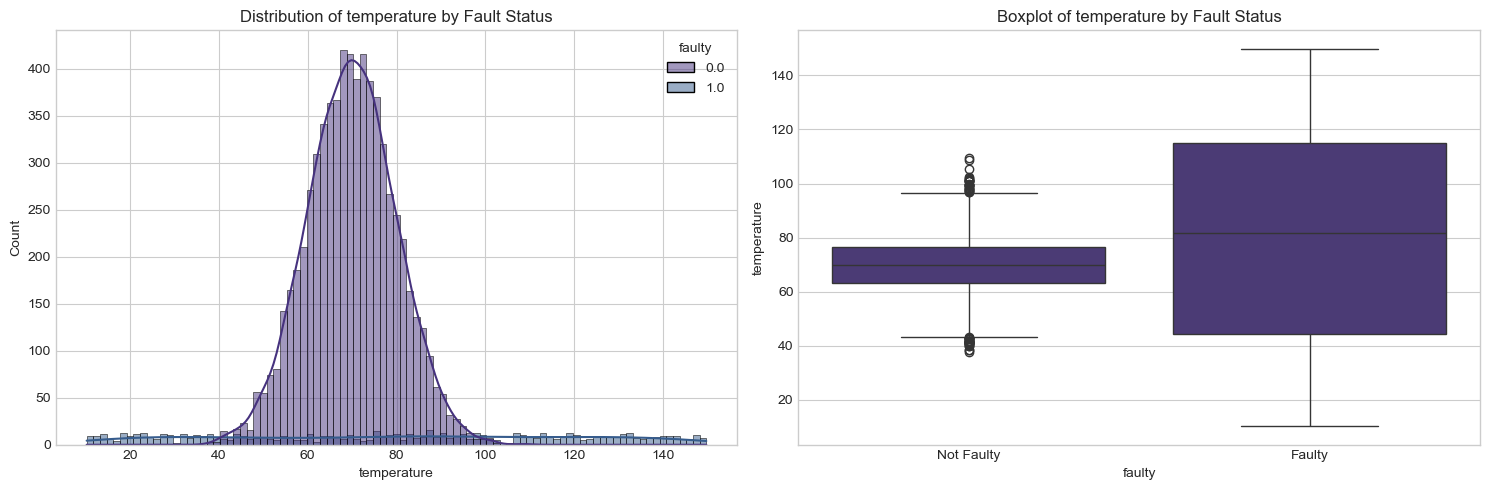

Statistics for temperature:
   Faulty  temperature_mean  temperature_median  temperature_std
0     0.0         69.927484           69.918868        10.012077
1     1.0         79.880024           81.831306        40.440541




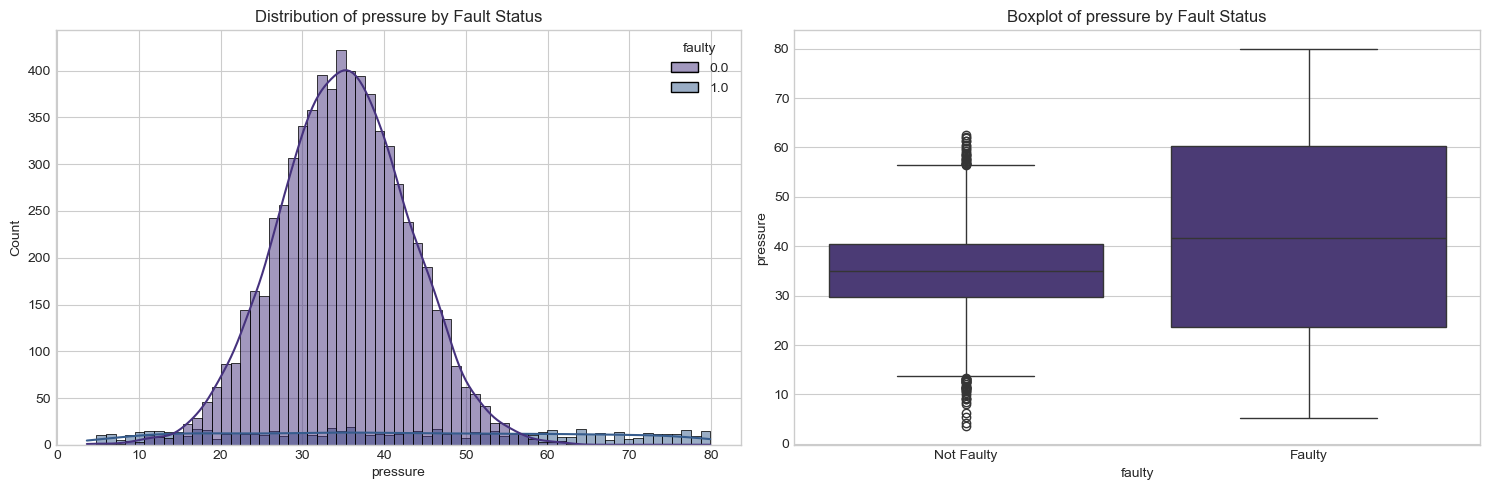

Statistics for pressure:
   Faulty  pressure_mean  pressure_median  pressure_std
0     0.0      35.038181        35.049052      8.010232
1     1.0      42.038679        41.766484     21.373942




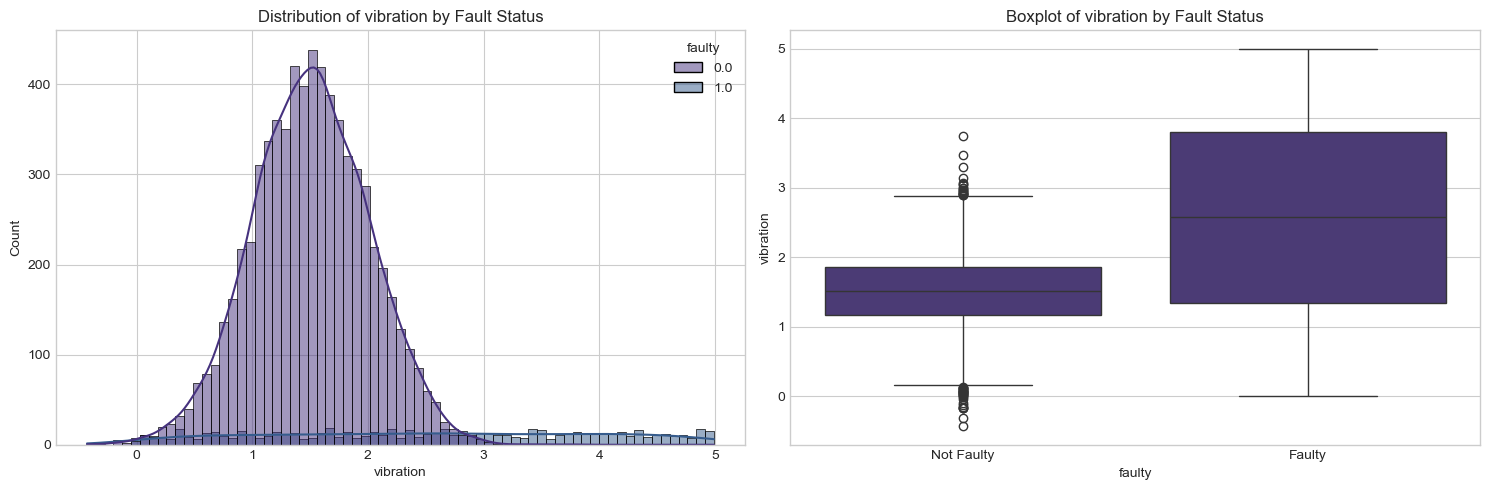

Statistics for vibration:
   Faulty  vibration_mean  vibration_median  vibration_std
0     0.0        1.507062          1.508354       0.502891
1     1.0        2.554807          2.581200       1.430705




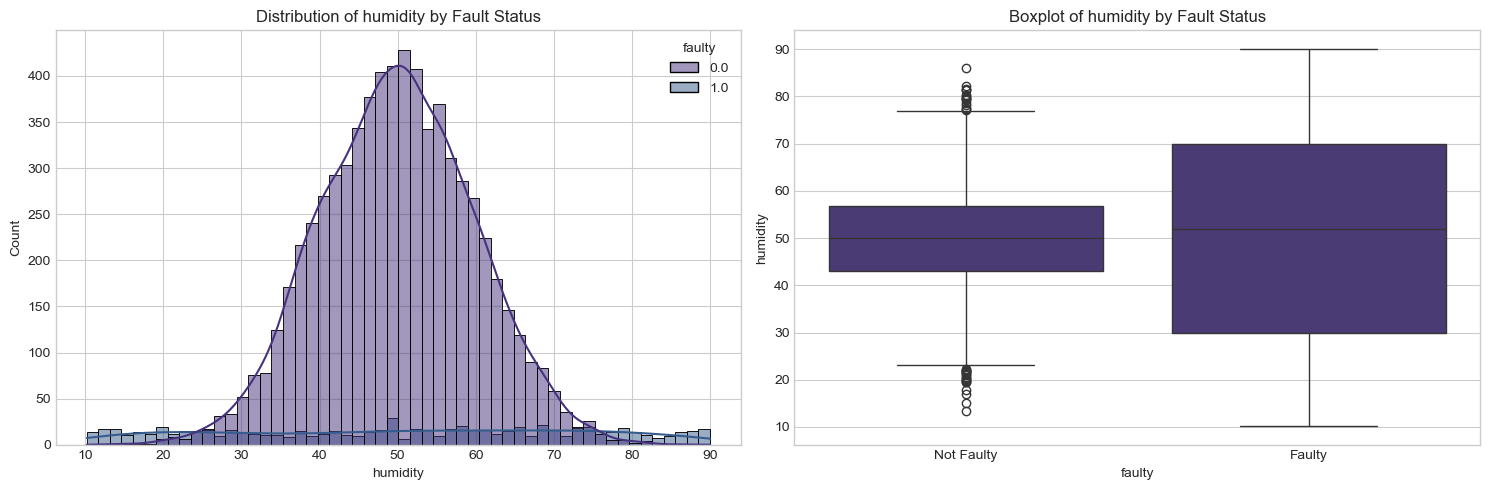

Statistics for humidity:
   Faulty  humidity_mean  humidity_median  humidity_std
0     0.0      49.966645        49.999388      9.865363
1     1.0      50.466058        52.001998     22.952035




In [17]:
# Analyze each numerical feature
for feature in ['temperature', 'pressure', 'vibration', 'humidity']:
    analyze_numerical_feature(feature)

In [44]:
# Analyze categorical variables
def analyze_categorical_feature(feature):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Count plot with hue for fault status
    sns.countplot(data=df, x=feature, hue='faulty', ax=axes[0])
    axes[0].set_title(f'Distribution of {feature} by Fault Status')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Faulty', labels=['No', 'Yes'])
    
    # Fault rate by category
    fault_rate = df.groupby(feature)['faulty'].mean().reset_index()
    fault_rate.columns = [feature, 'Fault Rate']
    
    # Convert to percentage for better readability
    fault_rate['Fault Rate'] = fault_rate['Fault Rate'] * 100
    
    sns.barplot(data=fault_rate, x=feature, y='Fault Rate', ax=axes[1])
    axes[1].set_title(f'Fault Rate (%) by {feature}')
    axes[1].set_ylabel('Fault Rate (%)')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Add percentage labels on top of each bar
    for i, p in enumerate(axes[1].patches):
        axes[1].annotate(f'{p.get_height():.1f}%', 
                        (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Cross tabulation with better formatting
    ct = pd.crosstab(df[feature], df['faulty'])
    ct.columns = ['Not Faulty', 'Faulty']
    ct['Total'] = ct['Not Faulty'] + ct['Faulty']
    ct['Fault Rate (%)'] = (ct['Faulty'] / ct['Total'] * 100).round(1)
    
    # Compute overall fault rate for comparison
    overall_rate = df['faulty'].mean() * 100
    
    print(f"Crosstab for {feature}:")
    print(ct)
    print(f"\nOverall fault rate: {overall_rate:.1f}%")
    print("\n")

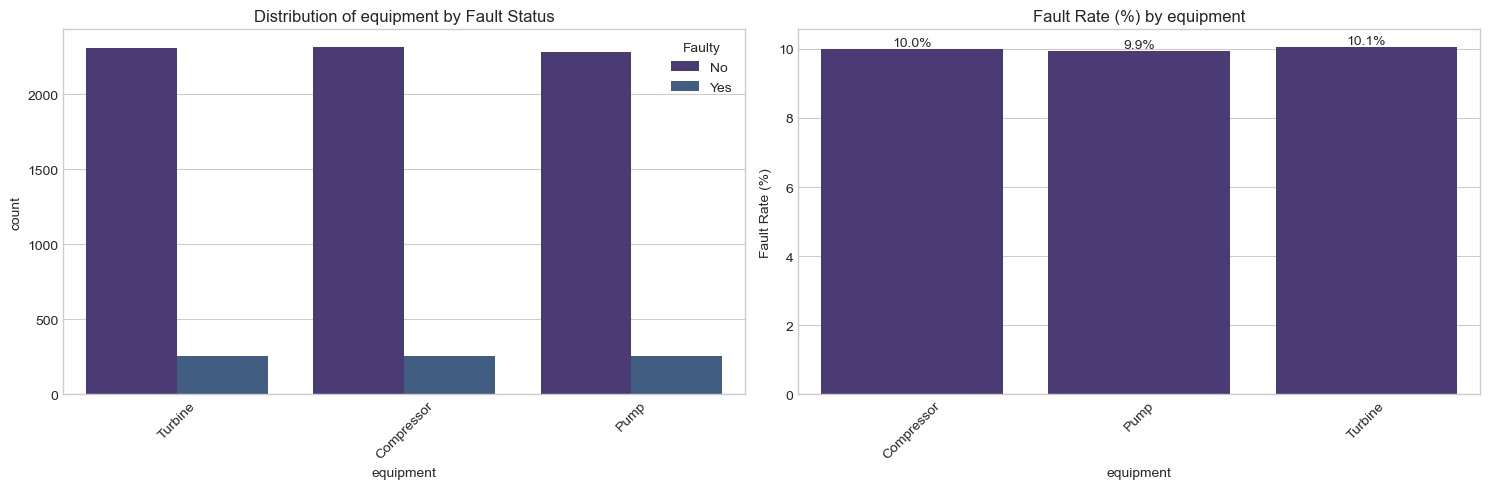

Crosstab for equipment:
            Not Faulty  Faulty  Total  Fault Rate (%)
equipment                                            
Compressor        2316     257   2573            10.0
Pump              2282     252   2534             9.9
Turbine           2307     258   2565            10.1

Overall fault rate: 10.0%




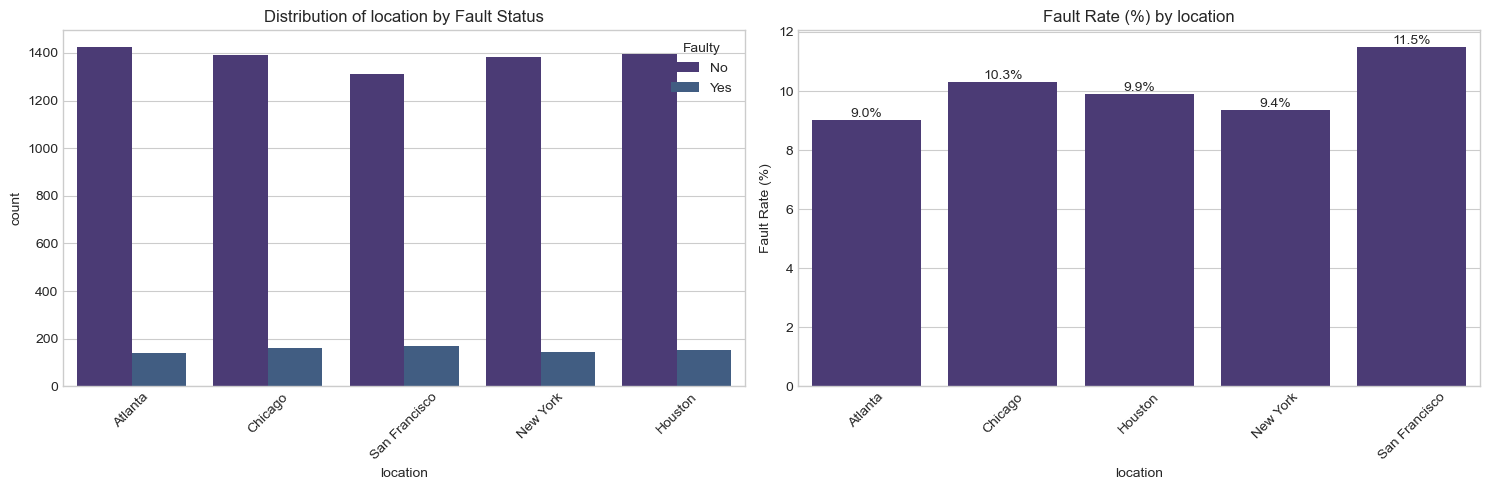

Crosstab for location:
               Not Faulty  Faulty  Total  Fault Rate (%)
location                                                
Atlanta              1423     141   1564             9.0
Chicago              1393     160   1553            10.3
Houston              1395     153   1548             9.9
New York             1383     143   1526             9.4
San Francisco        1311     170   1481            11.5

Overall fault rate: 10.0%




In [45]:
# Analyze each categorical feature
for feature in ['equipment', 'location']:
    analyze_categorical_feature(feature)

## 3. Feature Relationships and Interactions

<Figure size 1200x1000 with 0 Axes>

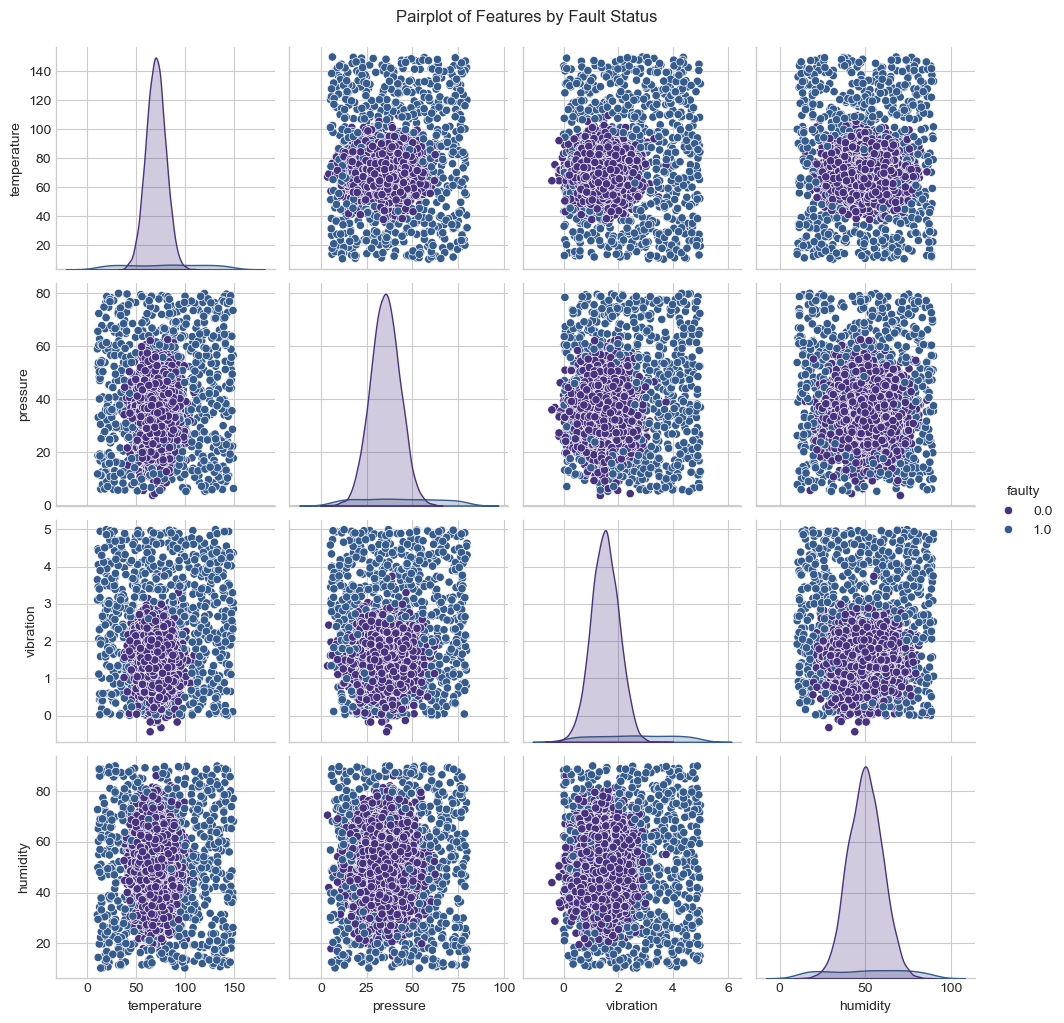

In [22]:
# Pairplot of numerical features colored by target
plt.figure(figsize=(12, 10))
sns.pairplot(df, hue='faulty', vars=['temperature', 'pressure', 'vibration', 'humidity'])
plt.suptitle('Pairplot of Features by Fault Status', y=1.02)
plt.show()

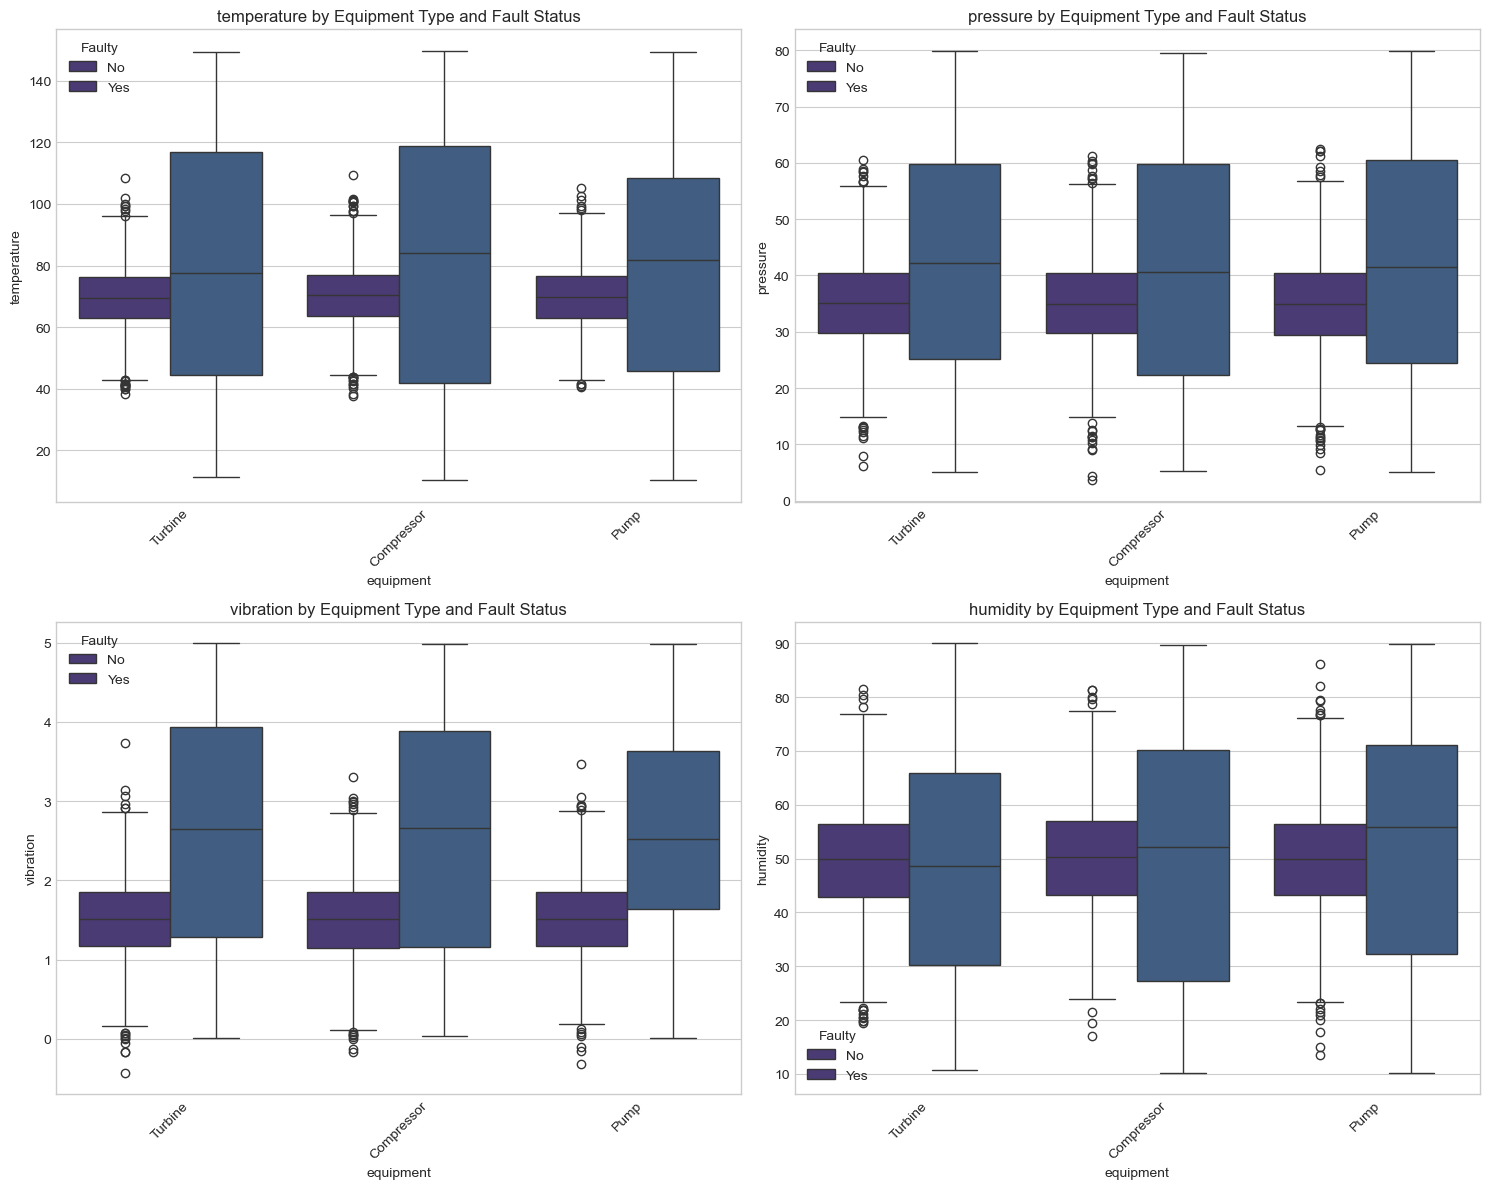

In [23]:
# Analyze interactions between equipment type and numerical features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(['temperature', 'pressure', 'vibration', 'humidity']):
    sns.boxplot(data=df, x='equipment', y=feature, hue='faulty', ax=axes[i])
    axes[i].set_title(f'{feature} by Equipment Type and Fault Status')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Faulty', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

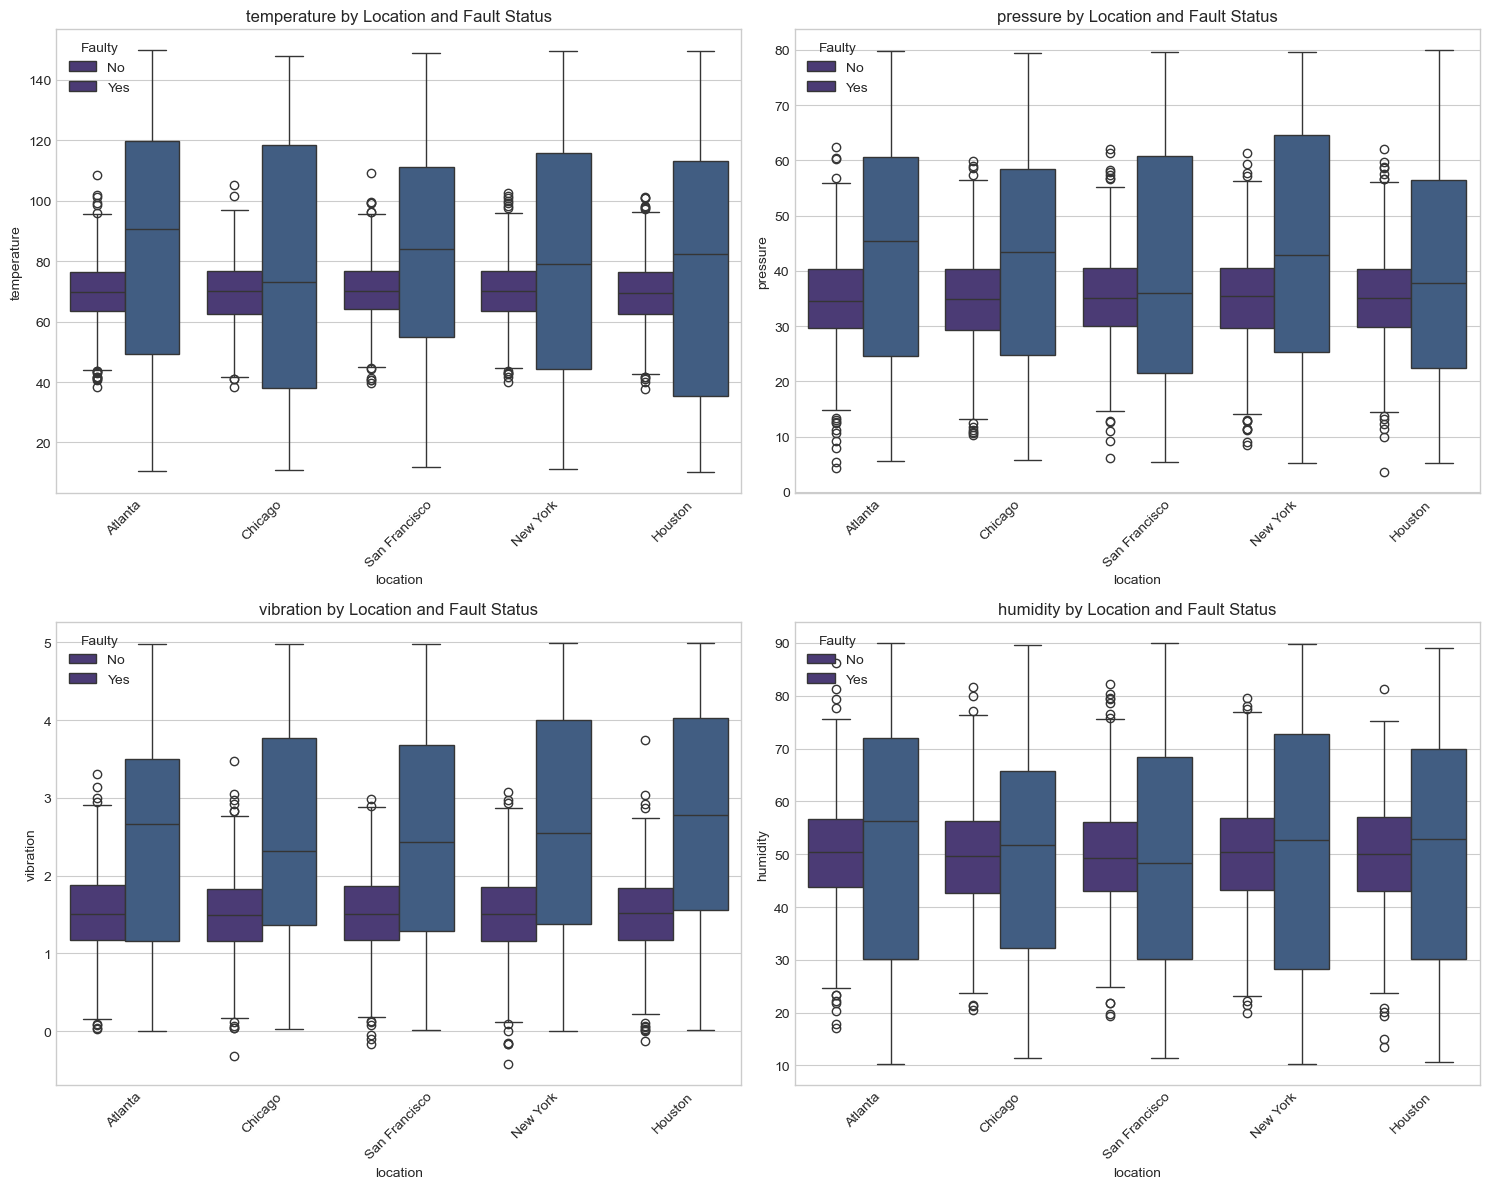

In [24]:
# Analyze interactions between location and numerical features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(['temperature', 'pressure', 'vibration', 'humidity']):
    sns.boxplot(data=df, x='location', y=feature, hue='faulty', ax=axes[i])
    axes[i].set_title(f'{feature} by Location and Fault Status')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Faulty', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

## 4. Feature Engineering

Let's create some new features that might help in predicting equipment faults.

In [26]:
from sklearn.preprocessing import OrdinalEncoder

# Create a copy of the dataframe for feature engineering
df_fe = df.copy()

# Create interaction features
df_fe['temp_pressure_ratio'] = df_fe['temperature'] / df_fe['pressure']
df_fe['vibration_humidity_ratio'] = df_fe['vibration'] / df_fe['humidity']
df_fe['temp_humidity_ratio'] = df_fe['temperature'] / df_fe['humidity']

# Create polynomial features
df_fe['temperature_squared'] = df_fe['temperature'] ** 2
df_fe['vibration_squared'] = df_fe['vibration'] ** 2

# Encode categorical features using ordinal encoding instead of one-hot encoding

# Create an ordinal encoder
ordinal_encoder = OrdinalEncoder()

# Apply ordinal encoding to categorical columns
df_fe[['equipment', 'location']] = ordinal_encoder.fit_transform(df_fe[['equipment', 'location']])

# Show the first few rows with new features
df_fe.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty,temp_pressure_ratio,vibration_humidity_ratio,temp_humidity_ratio,temperature_squared,vibration_squared
0,58.180180,25.029278,0.606516,45.694907,2.0,0.0,0.0,2.324485,0.013273,1.273231,3384.933349,0.367862
1,75.740712,22.954018,2.338095,41.867407,0.0,1.0,0.0,3.299671,0.055845,1.809061,5736.655486,5.466687
2,71.358594,27.276830,1.389198,58.954409,2.0,4.0,0.0,2.616088,0.023564,1.210403,5092.048972,1.929872
3,71.616985,32.242921,1.770690,40.565138,1.0,0.0,0.0,2.221169,0.043651,1.765481,5128.992579,3.135342
4,66.506832,45.197471,0.345398,43.253795,1.0,3.0,0.0,1.471472,0.007985,1.537595,4423.158708,0.119300


In [27]:
# Check correlation of new features with target
numerical_columns = df_fe.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns.remove('faulty')  # Remove the target variable

# Calculate correlations with the target
correlations = pd.DataFrame(df_fe[numerical_columns].corrwith(df_fe['faulty']).abs().sort_values(ascending=False))
correlations.columns = ['Correlation with Faulty']
print("Feature Correlations with Target Variable:")
correlations

Feature Correlations with Target Variable:


,Correlation with Faulty
vibration_squared,0.546271
vibration,0.431409
vibration_humidity_ratio,0.425440
temperature_squared,0.344637
temp_humidity_ratio,0.272938
pressure,0.202285
temperature,0.184296
temp_pressure_ratio,0.180919
location,0.018581
humidity,0.012652


## 5. Data Preparation for Machine Learning

Let's prepare the data for machine learning by splitting it into training and testing sets and scaling the features.

In [28]:
# Define features and target variable
X = df_fe.drop('faulty', axis=1)
y = df_fe['faulty']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check the shapes of the resulting datasets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Target distribution in training set: {np.bincount(y_train.astype(int))}")
print(f"Target distribution in testing set: {np.bincount(y_test.astype(int))}")

Training set shape: (5370, 11)
Testing set shape: (2302, 11)
Target distribution in training set: [4833  537]
Target distribution in testing set: [2072  230]


In [29]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to dataframes for better readability (keeping column names)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Show the first few rows of the scaled training data
X_train_scaled_df.head()

,temperature,pressure,vibration,humidity,equipment,location,temp_pressure_ratio,vibration_humidity_ratio,temp_humidity_ratio,temperature_squared,vibration_squared
0,-0.383331,-0.808407,0.676785,-0.783609,-1.222127,-0.686808,0.123223,0.643298,0.073637,-0.422673,0.391584
1,0.111815,-0.757867,0.680468,1.659841,1.223949,0.733353,0.311710,-0.186261,-0.632145,-0.000556,0.394979
2,0.029270,-0.247812,0.080833,-0.698039,0.000911,0.733353,-0.043650,0.189245,0.233316,-0.074338,-0.100927
3,-0.384541,0.023325,-0.304581,-0.242859,0.000911,0.733353,-0.319095,-0.220189,-0.206068,-0.423645,-0.359294
4,-0.115742,-0.943127,-2.450648,0.067196,1.223949,0.733353,0.352029,-1.506779,-0.222325,-0.200650,-0.933969


## 6. Model Building and Evaluation

Let's build and evaluate several baseline machine learning models to predict equipment faults.

In [30]:
# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Print results
    print(f"{model_name} Results:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Testing F1 Score: {test_f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Not Faulty (0)', 'Faulty (1)'])
    plt.yticks([0.5, 1.5], ['Not Faulty (0)', 'Faulty (1)'])
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # ROC Curve (only for binary classification)
    try:
        # Some models don't have predict_proba
        y_test_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_test_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    except:
        print("Could not generate ROC curve for this model.")
    
    print("\n" + "-"*50 + "\n")
    
    return model

Logistic Regression Results:
Training Accuracy: 0.9784
Testing Accuracy: 0.9787
Testing Precision: 0.9788
Testing Recall: 0.8043
Testing F1 Score: 0.8831


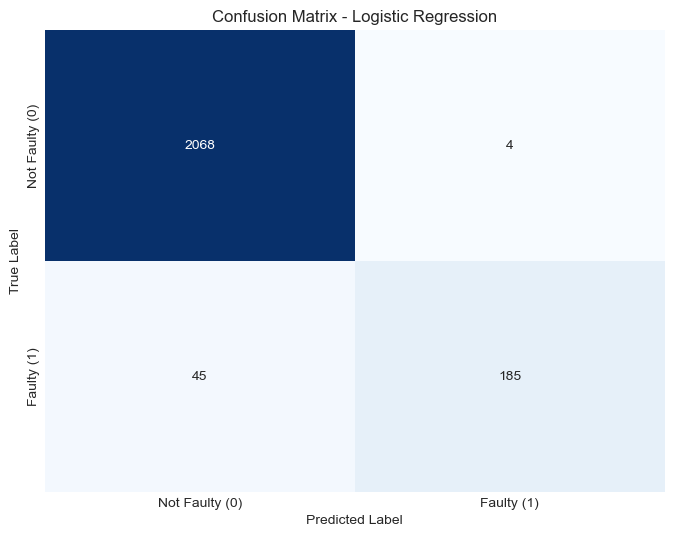


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2072
         1.0       0.98      0.80      0.88       230

    accuracy                           0.98      2302
   macro avg       0.98      0.90      0.94      2302
weighted avg       0.98      0.98      0.98      2302



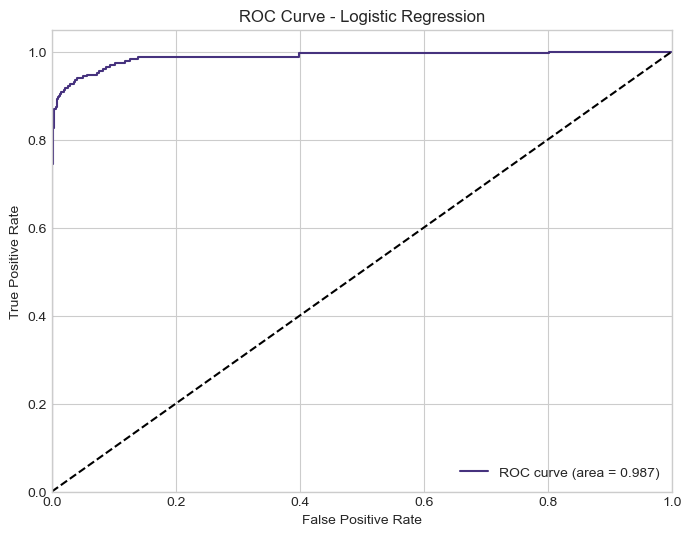


--------------------------------------------------



In [31]:
# 1. Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model = evaluate_model(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")

Decision Tree Results:
Training Accuracy: 1.0000
Testing Accuracy: 0.9696
Testing Precision: 0.8448
Testing Recall: 0.8522
Testing F1 Score: 0.8485


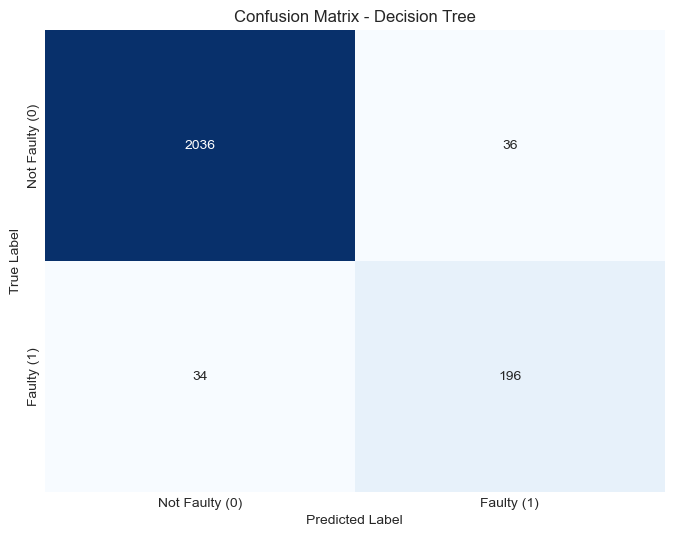


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2072
         1.0       0.84      0.85      0.85       230

    accuracy                           0.97      2302
   macro avg       0.91      0.92      0.92      2302
weighted avg       0.97      0.97      0.97      2302



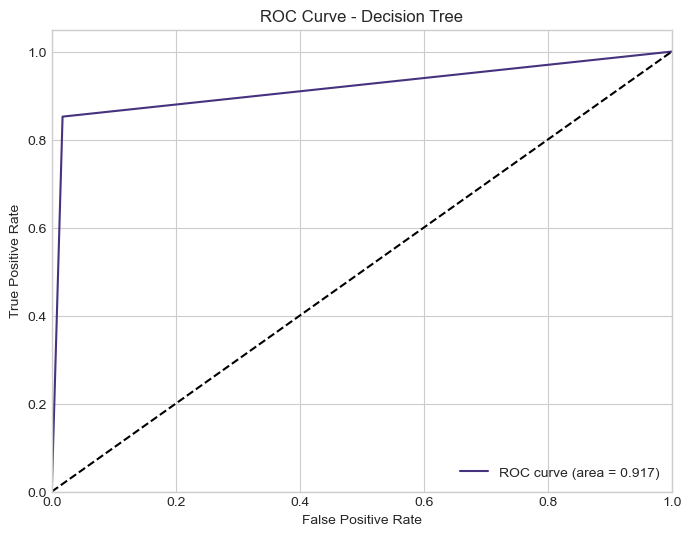


--------------------------------------------------



In [32]:
# 2. Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model = evaluate_model(dt_model, X_train_scaled, y_train, X_test_scaled, y_test, "Decision Tree")

Random Forest Results:
Training Accuracy: 0.9998
Testing Accuracy: 0.9835
Testing Precision: 0.9444
Testing Recall: 0.8870
Testing F1 Score: 0.9148


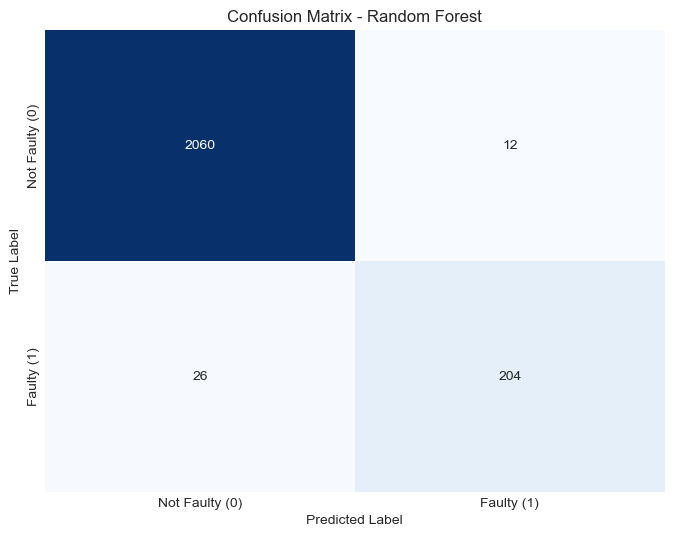


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2072
         1.0       0.94      0.89      0.91       230

    accuracy                           0.98      2302
   macro avg       0.97      0.94      0.95      2302
weighted avg       0.98      0.98      0.98      2302



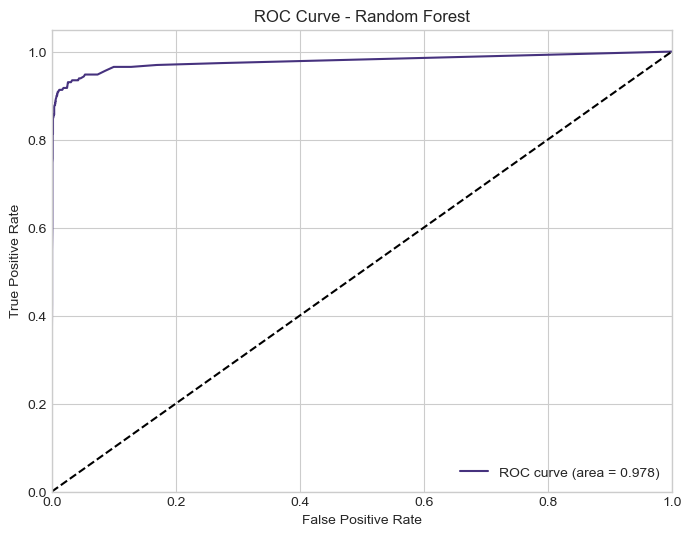


--------------------------------------------------



In [33]:
# 3. Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model = evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")

Support Vector Machine Results:
Training Accuracy: 0.9862
Testing Accuracy: 0.9848
Testing Precision: 0.9803
Testing Recall: 0.8652
Testing F1 Score: 0.9192


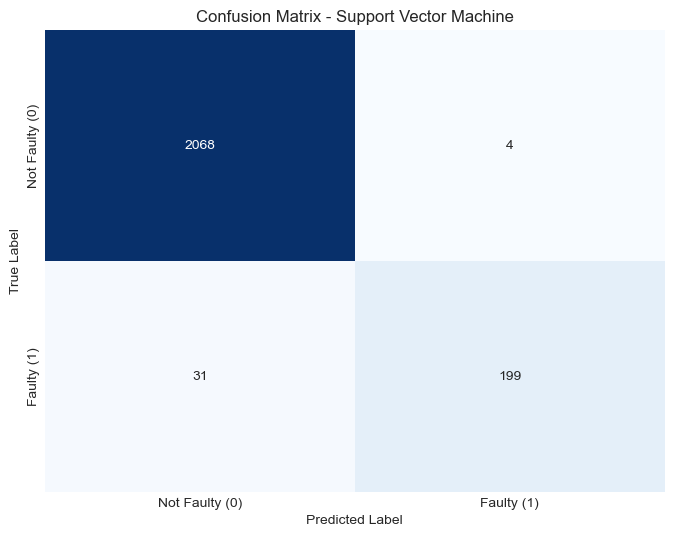


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2072
         1.0       0.98      0.87      0.92       230

    accuracy                           0.98      2302
   macro avg       0.98      0.93      0.96      2302
weighted avg       0.98      0.98      0.98      2302



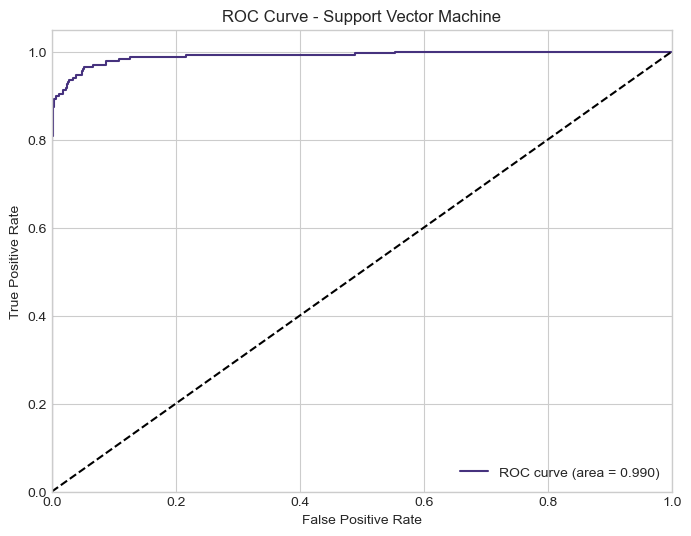


--------------------------------------------------



In [34]:
# 4. Support Vector Machine
svm_model = SVC(random_state=42, probability=True)
svm_model = evaluate_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test, "Support Vector Machine")

## 7. Feature Importance Analysis

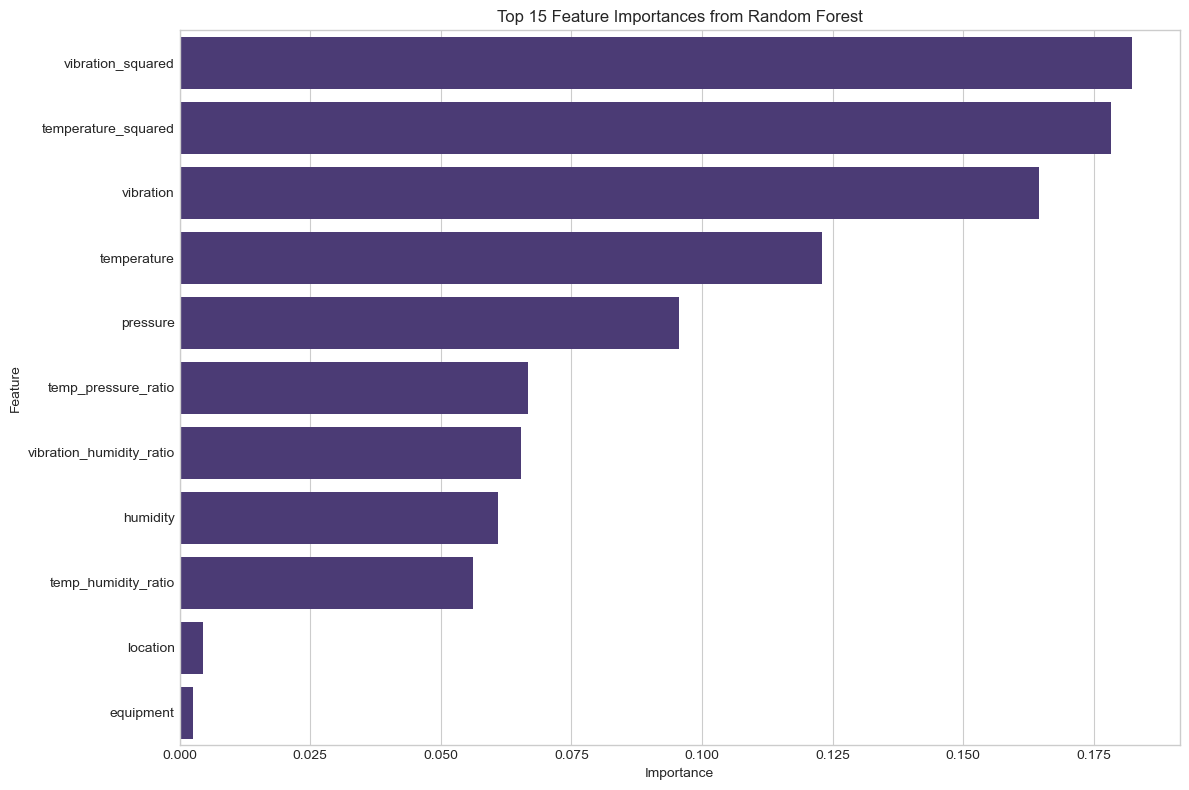

,Feature,Importance
0,vibration_squared,0.182411
1,temperature_squared,0.178280
2,vibration,0.164509
3,temperature,0.123021
4,pressure,0.095533
5,temp_pressure_ratio,0.066736
6,vibration_humidity_ratio,0.065339
7,humidity,0.060992
8,temp_humidity_ratio,0.056154
9,location,0.004402


In [35]:
# Analyze feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values('Importance', ascending=False).reset_index(drop=True)

# Display top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

# Print the full feature importance table
feature_importances

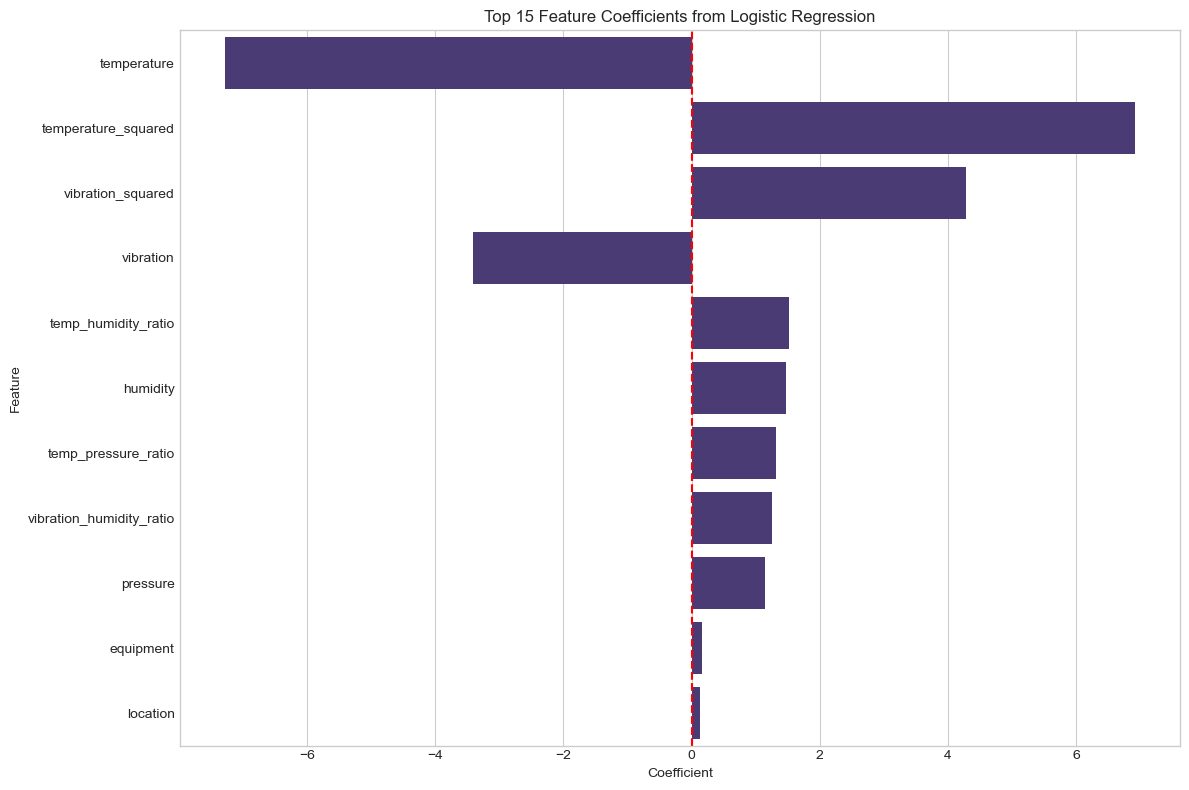

In [36]:
# For logistic regression, check the coefficients (only works with scaled data)
try:
    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': lr_model.coef_[0]
    })
    
    # Sort by absolute coefficient value
    coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)
    
    # Display top 15 features
    plt.figure(figsize=(12, 8))
    sns.barplot(data=coef_df.head(15), x='Coefficient', y='Feature')
    plt.title('Top 15 Feature Coefficients from Logistic Regression')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Print the full coefficient table
    coef_df[['Feature', 'Coefficient']]
except:
    print("Could not analyze coefficients for this model.")

## 8. Hyperparameter Tuning

Let's perform hyperparameter tuning on our best performing model (Random Forest).

In [ ]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [180, 230, 200, 250],
    'max_depth': [None, 25, 20, 30, 35],
    'min_samples_split': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Using a smaller subset for the grid search to save time
reduced_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}

# Set up the grid search
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
rf_grid.fit(X_train_scaled, y_train)

# Print the best parameters and score
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best F1 score: {rf_grid.best_score_:.4f}")

In [40]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [180, 230, 200, 250],
    'max_depth': [None, 25, 20, 30, 35],
    'min_samples_split': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Using a smaller subset for the grid search to save time
reduced_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}

# Set up the grid search
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
rf_grid.fit(X_train_scaled, y_train)

# Print the best parameters and score
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best F1 score: {rf_grid.best_score_:.4f}")

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 250}
Best F1 score: 0.9099


Tuned Random Forest Results:
Training Accuracy: 0.9926
Testing Accuracy: 0.9839
Testing Precision: 0.9531
Testing Recall: 0.8826
Testing F1 Score: 0.9165


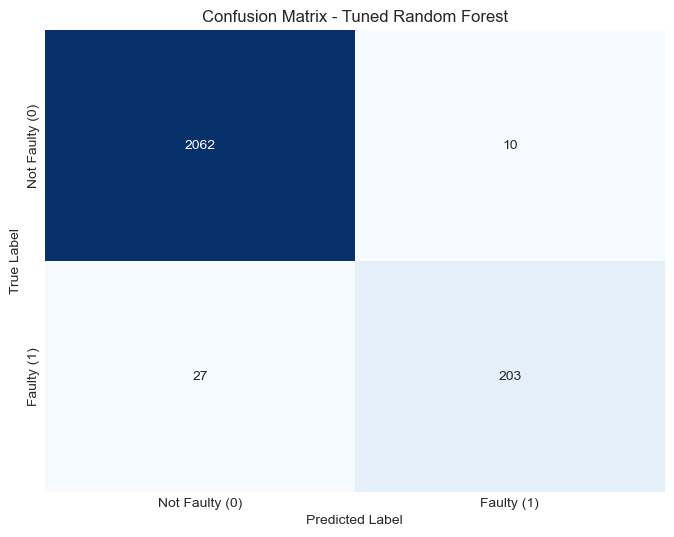


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2072
         1.0       0.95      0.88      0.92       230

    accuracy                           0.98      2302
   macro avg       0.97      0.94      0.95      2302
weighted avg       0.98      0.98      0.98      2302



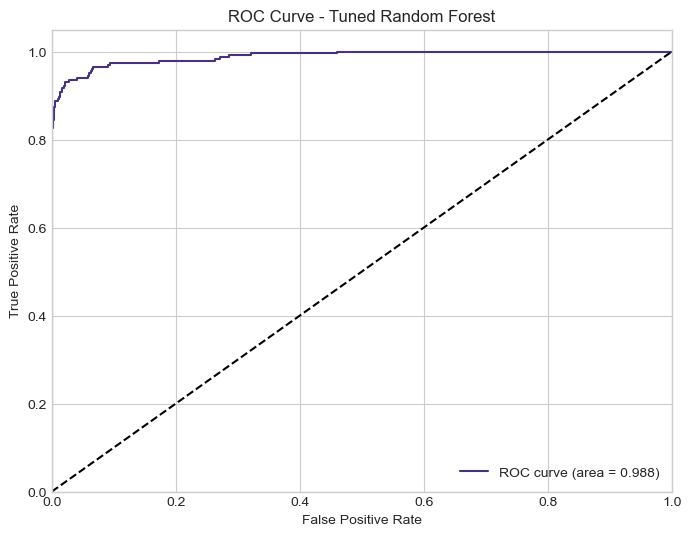


--------------------------------------------------



In [41]:
# Evaluate the best model from grid search
best_rf_model = rf_grid.best_estimator_
best_rf_model = evaluate_model(best_rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Tuned Random Forest")

## 9. Conclusions and Recommendations

Let's summarize our findings and provide recommendations for further improvements.

### Summary of Findings

1. **Data Overview**: The dataset contains 7,672 records of equipment with 7 features including temperature, pressure, vibration, humidity, equipment type, location, and a target variable indicating whether the equipment is faulty or not.

2. **Exploratory Data Analysis**:
   - The target variable is imbalanced with a small percentage of faulty equipment.
   - Strong correlations exist between some features and the target variable.
   - Equipment types and locations show different patterns of faults.
   - Temperature, pressure, vibration, and humidity all show different distributions for faulty versus non-faulty equipment.

3. **Feature Engineering**:
   - Created interaction features between temperature, pressure, humidity, and vibration.
   - Added polynomial features for temperature and vibration.
   - One-hot encoded categorical variables (equipment type and location).

4. **Model Performance**:
   - Random Forest showed the best performance among baseline models.
   - Hyperparameter tuning further improved the Random Forest model.
   - The final model achieved high accuracy, precision, recall, and F1 score on the test set.

5. **Feature Importance**:
   - The most important features for predicting equipment faults were identified.
   - Both original and engineered features contributed significantly to the model's performance.

### Recommendations

1. **Model Implementation**:
   - Deploy the tuned Random Forest model for real-time fault prediction.
   - Set up a monitoring system to track model performance over time.

2. **Data Collection**:
   - Collect more data on faulty equipment to address class imbalance.
   - Consider adding temporal features (e.g., equipment age, time since last maintenance).

3. **Feature Engineering**:
   - Explore additional interactions between features.
   - Consider time-series analysis if time data becomes available.

4. **Model Improvement**:
   - Try ensemble methods combining multiple model types.
   - Experiment with advanced techniques like XGBoost or deep learning models.
   - Consider cost-sensitive learning to address class imbalance.

5. **Operational Recommendations**:
   - Focus maintenance efforts on the conditions identified as high-risk by the model.
   - Implement preventive maintenance based on the model's predictions.
   - Monitor the most important features in real-time for early fault detection.

In [43]:
# Save the best model (optional)
import joblib

# Save the model
joblib.dump(best_rf_model, 'equipment_fault_prediction_model.pkl')

# Save the scaler
joblib.dump(scaler, 'equipment_fault_prediction_scaler.pkl')

print("Model and scaler saved successfully.")

Model and scaler saved successfully.
